<a href="https://colab.research.google.com/github/tysonbarreto/GANs/blob/main/CIFAR_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split

import torchvision
from torchvision.transforms import ToTensor,Compose,RandomCrop,RandomHorizontalFlip,Normalize
from torchvision.datasets import CIFAR10
from torchvision.utils import make_grid

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline

import pickle
import numpy as np

In [ ]:
torch.cuda.is_available()

True

In [ ]:
dataset = CIFAR10(root = 'data/', download=True, transform=ToTensor())

100%|██████████| 170498071/170498071 [00:13<00:00, 13095194.75it/s]


Extracting data/cifar-10-python.tar.gz to data/


In [ ]:
len(dataset)

50000

In [ ]:
mean1 = [images[0].mean().item() for images, labels in dataset]
mean2 = [images[1].mean().item() for images, labels in dataset]
mean3 = [images[2].mean().item() for images, labels in dataset]
std1 = [images[0].std().item() for images, labels in dataset]
std2 = [images[1].std().item() for images, labels in dataset]
std3 = [images[2].std().item() for images, labels in dataset]

In [ ]:
mean1 = np.mean(mean1)
mean2 = np.mean(mean2)
mean3 = np.mean(mean3)
std1 = np.mean(std1)
std2 = np.mean(std2)
std3 = np.mean(std3)

#stats =((mean1,mean2,mean3),(std1,std2,std3))
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))


## **Normalizing the dataset**

Create training and validation datasets using the `ImageFolder` class from `torchvision`. In addition to the `ToTensor` transform, we'll also apply some other transforms to the images. There are a few important changes we'll make while creating PyTorch datasets for training and validation:

1. **Use test set for validation**: Instead of setting aside a fraction (e.g. 10%) of the data from the training set for validation, we'll simply use the test set as our validation set. This just gives a little more data to train with. In general, once you have picked the best model architecture & hypeparameters using a fixed validation set, it is a good idea to retrain the same model on the entire dataset just to give it a small final boost in performance.
2. **Channel-wise data normalization**: We will normalize the image tensors by subtracting the mean and dividing by the standard deviation across each channel. As a result, the mean of the data across each channel is 0, and standard deviation is 1. Normalizing the data prevents the values from any one channel from disproportionately affecting the losses and gradients while training, simply by having a higher or wider range of values that others.

    <img src="https://i.imgur.com/LYxXBVg.png" width="360">





3. **Randomized data augmentations**: We will apply randomly chosen transformations while loading images from the training dataset. Specifically, we will pad each image by 4 pixels, and then take a random crop of size 32 x 32 pixels, and then flip the image horizontally with a 50% probability. Since the transformation will be applied randomly and dynamically each time a particular image is loaded, the model sees slightly different images in each epoch of training, which allows it generalize better.


In [ ]:
train_tfms = Compose([RandomCrop(32, padding = 4, padding_mode='reflect'),
                     RandomHorizontalFlip(),
                     ToTensor(),
                     Normalize(*stats, inplace=True)])

val_tfms = Compose([ToTensor(),Normalize(*stats)])


In [ ]:
train_ds = CIFAR10(root='data/',train=True,transform=train_tfms)
val_ds = CIFAR10(root='data/',train=False,transform=val_tfms)

In [ ]:
def denormalize(images,*stats):
  means, stds = stats
  means = torch.tensor(means).reshape(3,1,1)
  stds = torch.tensor(stds).reshape(3,1,1)
  images = images * stds + means
  return images

In [ ]:
def show_image(image, label):
  plt.axis('off')
  plt.imshow(image.permute(1,2,0))
  return dataset.classes[label]

'automobile'

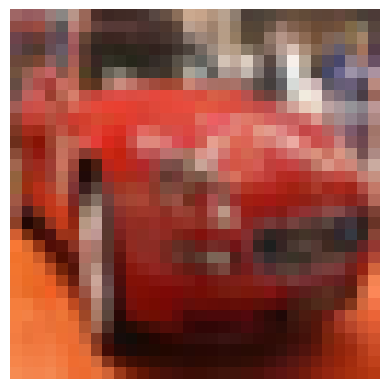

In [ ]:
images,labels = dataset[5]
show_image(images,labels)

'automobile'

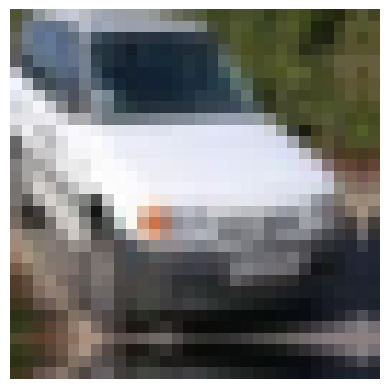

In [ ]:
  images, labels = train_ds[46]
  images=denormalize(images,*stats)
  show_image(images,labels)
  train_ds.classes[labels]

In [ ]:
train_dl = DataLoader(train_ds,batch_size=512,shuffle=True,num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds,batch_size=512*2,num_workers=4, pin_memory=True)

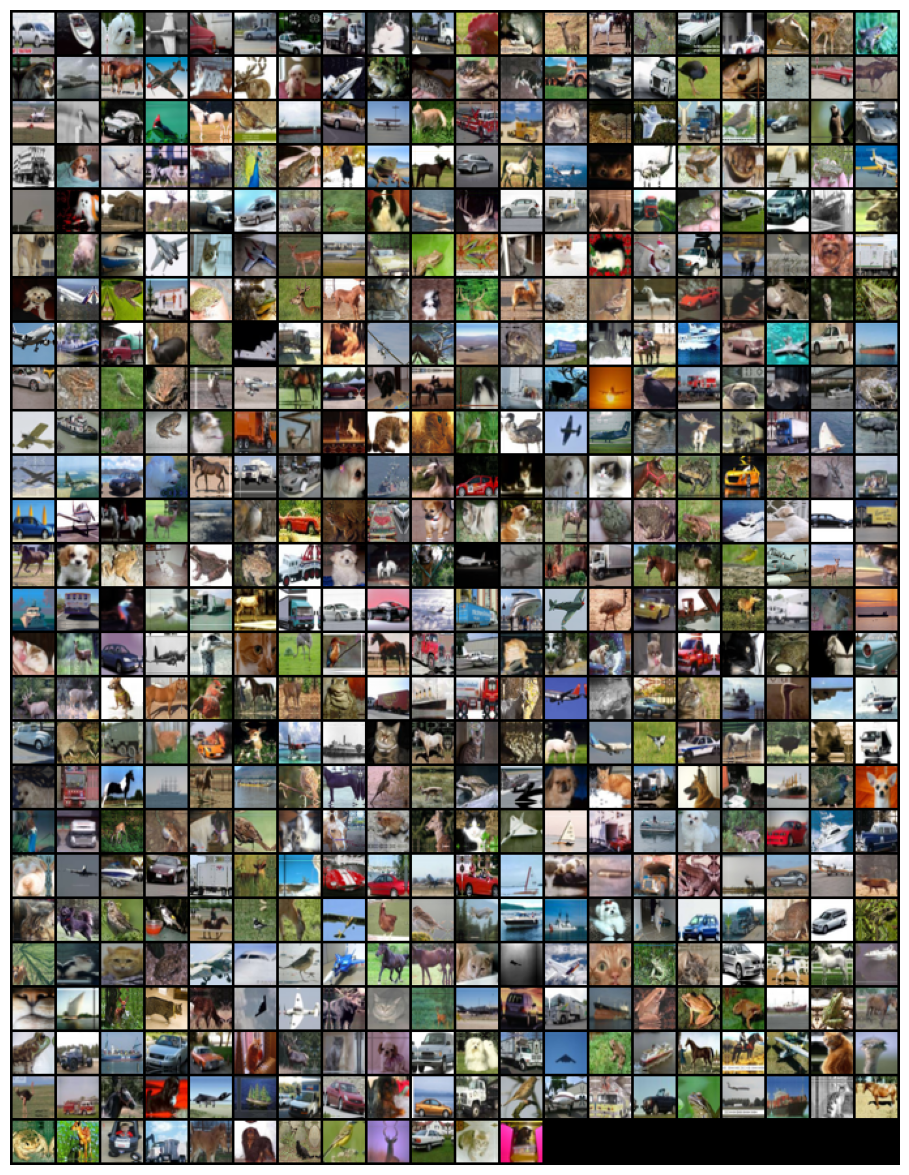

In [ ]:
for images, labels in train_dl:
  images = denormalize(images, *stats)
  fig,ax = plt.subplots(figsize=(15,15))
  ax.axis('off')
  ax.imshow(make_grid(images,nrow=20).permute(1,2,0))
  break

### Functions to move data and model to the GPU

In [ ]:
def get_default_device():
  if torch.cuda.is_available(): return torch.device('cuda')
  else: return torch.device('cpu')

def to_device(data, device):
  if isinstance(data, (list,tuple)):
    return [to_device(batch, device) for batch in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    for batch in self.dl:
      yield to_device(batch,self.device)

  def __len__(self):
    return len(self.dl)


In [ ]:
device=get_default_device()

### Training and Evaluating the Model

## Model with Residual Blocks and Batch Normalization

![](https://miro.medium.com/max/1140/1*D0F3UitQ2l5Q0Ak-tjEdJg.png)


In [ ]:
def accuracy(outputs,labels):
  _,preds = torch.max(outputs,dim=1)
  acc=torch.sum(preds==labels).item()/len(preds)
  return torch.tensor(acc)

class ImageClassification(nn.Module):
  def training_step(self,batch):
    images, labels = batch
    out = self.forward(images)
    loss = F.cross_entropy(out,labels)
    return loss

  def validation_step(self,batch):
    images, labels = batch
    out = self.forward(images)
    loss = F.cross_entropy(out,labels)
    acc = accuracy(out,labels)
    return {'val_acc':acc,'val_loss':loss.detach()}

  def validation_epoch_end(self,outputs):
    batch_loss = [x['val_loss'] for x in outputs]
    batch_acc = [x['val_acc'] for x in outputs]
    epoch_loss = torch.stack(batch_loss).mean()
    epoch_acc = torch.stack(batch_acc).mean()
    return {'val_acc':epoch_acc.item(),'val_loss':epoch_loss.item()}
    #return batch_acc

  def epoch_end(self, epoch, result):
    print(f"Epoch [{epoch}] -> lrs:{result['lrs'][-1]}, train_loss:{result['train_loss']}, val_loss:{result['val_loss']}, val_acc:{result['val_acc']} ")



class CNNModel(ImageClassification):
  def __init__(self,in_channels,num_classes):
    super().__init__()
    #256 is the batch size
    self.network = nn.Sequential(
                #3 x 32 x 32
                nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                #32 x 32 x 32
                nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                #64 x 32 x 32
                nn.MaxPool2d(2), # 64 x 16 x 16

                nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                #128 x 16 x 16
                nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                #128 x 16 x 16
                nn.MaxPool2d(2), #128 x 8 x 8

                nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                #256 x 8 x 8
                nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                #256 x 8 x 8
                nn.MaxPool2d(2), # 256 x 4 x 4

                nn.Flatten(),
                nn.Linear(256 * 4 * 4, 32 * 32),
                nn.ReLU(),
                nn.Linear(32 * 32, 512),
                nn.ReLU(),
                nn.Linear(512, num_classes))
  def forward(self, xb):
    return self.network(xb)

def conv_block(in_channels, out_channels, pool=False):
  layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1 ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)]
  if pool: layers.append(nn.MaxPool2d(2))
  return nn.Sequential(*layers)

class ResNet9(ImageClassification):
  def __init__(self,in_channels,num_classes):
    super().__init__()
    self.conv1 = conv_block(in_channels, 64)
    self.conv2 = conv_block(64, 128, pool = True)
    self.res1 = nn.Sequential(conv_block(128,128), conv_block(128,128))

    self.conv3 = conv_block(128, 256, pool=True)
    self.conv4 = conv_block(256, 512, pool=True)
    self.res2 = nn.Sequential(conv_block(512,512), conv_block(512,512))

    self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                    nn.Flatten(),
                                    nn.Dropout(0.2),
                                    nn.Linear(512,num_classes)
                                    )
  def forward(self, xb):
    out = self.conv1(xb)
    out = self.conv2(out)
    out = self.res1(out) + out

    out = self.conv3(out)
    out = self.conv4(out)
    out = self.res2(out) + out

    out = self.classifier(out)
    return out

* **Learning rate scheduling**: Instead of using a fixed learning rate, we will use a learning rate scheduler, which will change the learning rate after every batch of training. There are many strategies for varying the learning rate during training, and the one we'll use is called the **"One Cycle Learning Rate Policy"**, which involves starting with a low learning rate, gradually increasing it batch-by-batch to a high learning rate for about 30% of epochs, then gradually decreasing it to a very low value for the remaining epochs.

* **Weight decay**: We also use weight decay, which is yet another regularization technique which prevents the weights from becoming too large by adding an additional term to the loss function.

* **Gradient clipping**: Apart from the layer weights and outputs, it also helpful to limit the values of gradients to a small range to prevent undesirable changes in parameters due to large gradient values. This simple yet effective technique is called gradient clipping.

In [ ]:
model=ResNet9(3,10)

In [ ]:
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [ ]:
@torch.no_grad()
def evaluate(model,val_dl):
  model.eval()
  outputs=[model.validation_step(batch) for batch in val_dl]
  return model.validation_epoch_end(outputs)

def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return (param_group['lr'])

In [ ]:
def fit(epochs,model,max_lr,train_dl,val_dl,weight_decay=0,grad_clip=None,opt_function=torch.optim.SGD):

  torch.cuda.empty_cache()

  history = []

  optimizer = opt_function(model.parameters(),
                           lr=max_lr,
                           weight_decay=weight_decay)

  scheduler=torch.optim.lr_scheduler.OneCycleLR(optimizer,
                                                max_lr,
                                                epochs=epochs,
                                                steps_per_epoch=len(train_dl))

  for epoch in range(epochs):
    model.train()
    train_loss=[]
    lrs=[]
    for batch in train_dl:
      loss = model.training_step(batch)
      train_loss.append(loss)
      loss.backward()

      if grad_clip:
        nn.utils.clip_grad_value_(model.parameters(), grad_clip)

      optimizer.step()
      optimizer.zero_grad()

      lrs.append(get_lr(optimizer))
      scheduler.step()

    result = evaluate(model,val_dl)
    result['train_loss']= torch.stack(train_loss).mean().item()
    result['lrs'] = lrs
    model.epoch_end(epoch,result)
    history.append(result)
  return history

### Moving the dataloaders and model to GPU before training and validation

In [ ]:
device

device(type='cuda')

In [ ]:
model = to_device(model, device)
train_dl = DeviceDataLoader(train_dl,device)
val_dl = DeviceDataLoader(val_dl,device)

In [ ]:
history = [evaluate(model, val_dl)]

In [ ]:
epochs=10
max_lr=0.01
weight_decay=1e-4
grad_clip=0.1
opt_function=torch.optim.Adam

In [ ]:
%%time
history += fit(epochs,
               model,
               max_lr,
               train_dl,
               val_dl,
               weight_decay=weight_decay,
               grad_clip=grad_clip,
               opt_function=opt_function)

Epoch [0] -> lrs:0.0027703474480091604, train_loss:1.5403016805648804, val_loss:1.478838324546814, val_acc:0.5007911920547485 
Epoch [1] -> lrs:0.007585127643381374, train_loss:1.034468173980713, val_loss:1.5823296308517456, val_acc:0.5600984692573547 
Epoch [2] -> lrs:0.01, train_loss:0.9455922842025757, val_loss:0.97564297914505, val_acc:0.6822425127029419 
Epoch [3] -> lrs:0.009504846320134737, train_loss:0.6976640224456787, val_loss:0.7980378270149231, val_acc:0.7168307304382324 
Epoch [4] -> lrs:0.008117456539497631, train_loss:0.5539635419845581, val_loss:0.7689687609672546, val_acc:0.7409418821334839 
Epoch [5] -> lrs:0.0061126202193628925, train_loss:0.4731486141681671, val_loss:0.5631621479988098, val_acc:0.8047950863838196 
Epoch [6] -> lrs:0.003887419780637108, train_loss:0.3915930688381195, val_loss:0.4000982344150543, val_acc:0.8680524826049805 
Epoch [7] -> lrs:0.00188258346050237, train_loss:0.3056041896343231, val_loss:0.36260730028152466, val_acc:0.8752849698066711 
Ep

In [ ]:
%%time
history += fit(epochs,
               model,
               max_lr,
               train_dl,
               val_dl,
               weight_decay=weight_decay,
               grad_clip=grad_clip,
               opt_function=opt_function)

Epoch [0] -> lrs:0.0027703474480091604, train_loss:0.24072296917438507, val_loss:0.7324902415275574, val_acc:0.7989795804023743 
Epoch [1] -> lrs:0.007585127643381374, train_loss:0.4691353440284729, val_loss:1.0076297521591187, val_acc:0.7062579393386841 
Epoch [2] -> lrs:0.01, train_loss:0.5451027750968933, val_loss:0.8505102396011353, val_acc:0.708516001701355 
Epoch [3] -> lrs:0.009504846320134737, train_loss:0.4818229675292969, val_loss:0.5385934114456177, val_acc:0.8190290331840515 
Epoch [4] -> lrs:0.008117456539497631, train_loss:0.44077253341674805, val_loss:0.7694689631462097, val_acc:0.7666693329811096 
Epoch [5] -> lrs:0.0061126202193628925, train_loss:0.38755932450294495, val_loss:0.4210301339626312, val_acc:0.8580158352851868 
Epoch [6] -> lrs:0.003887419780637108, train_loss:0.3196801543235779, val_loss:0.3991822600364685, val_acc:0.8663862943649292 
Epoch [7] -> lrs:0.00188258346050237, train_loss:0.24657689034938812, val_loss:0.312071293592453, val_acc:0.894868075847625

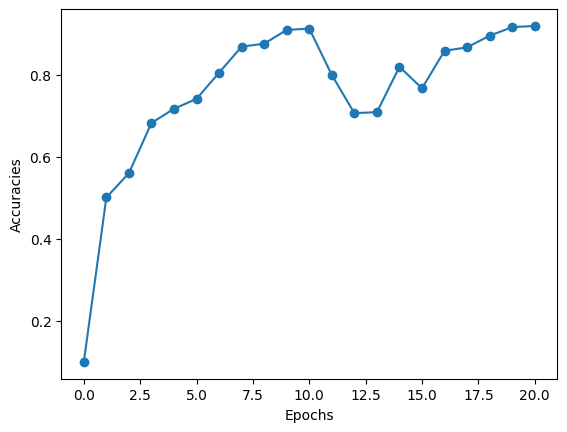

In [ ]:
val_acc=[x['val_acc'] for x in history]
plt.plot(val_acc,'o-')
plt.xlabel('Epochs')
plt.ylabel('Accuracies')
plt.show()

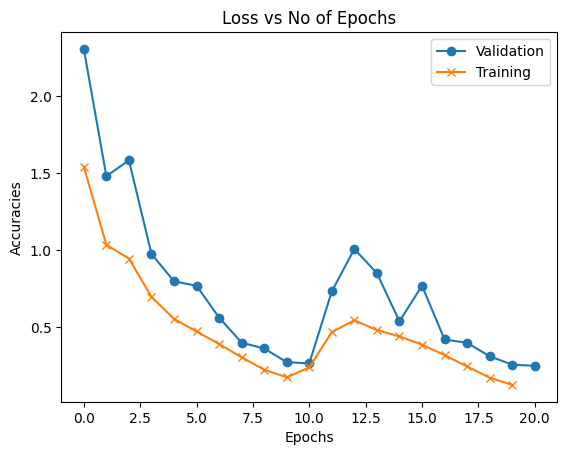

In [ ]:
val_loss = [x['val_loss'] for x in history]
train_loss = [x['train_loss'] for x in history[1:]]
plt.plot(val_loss,'o-')
plt.plot(train_loss,'x-')
plt.xlabel('Epochs')
plt.ylabel('Accuracies')
plt.title('Loss vs No of Epochs')
plt.legend(['Validation','Training'])
plt.show()

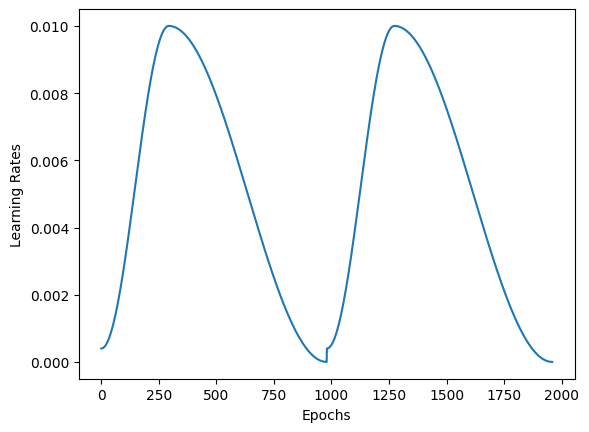

In [ ]:
lrs = np.concatenate([(x['lrs']) for x in history[1:]])
plt.plot(lrs)
plt.xlabel('Epochs')
plt.ylabel('Learning Rates')
plt.show()

### Testing images

Prediction: deer, Actual: deer


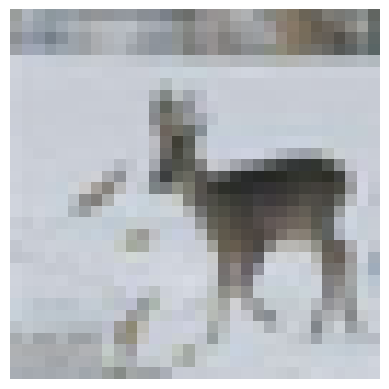

In [ ]:
image, label = dataset[20]
xb = to_device(image.unsqueeze(0),device)
out = model(xb)
_, preds = torch.max(out, dim=1)
print(f"Prediction: {dataset.classes[preds[0].item()]}, Actual: {dataset.classes[label]}")
plt.axis('off')
plt.imshow(image.permute(1, 2, 0).clamp(0, 1))

Prediction: bird, Actual: bird


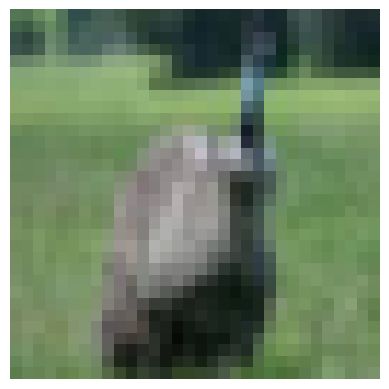

In [ ]:
image, label = dataset[1050]
xb = to_device(image.unsqueeze(0),device)
out = model(xb)
_, preds = torch.max(out, dim=1)
print(f"Prediction: {dataset.classes[preds[0].item()]}, Actual: {dataset.classes[label]}")
plt.axis('off')
plt.imshow(image.permute(1, 2, 0))
plt.show()

Prediction: ship, Actual: ship


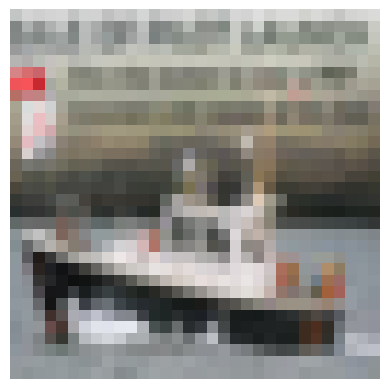

In [ ]:
image, label = dataset[4995]
xb = to_device(image.unsqueeze(0),device)
out = model(xb)
_, preds = torch.max(out, dim=1)
print(f"Prediction: {dataset.classes[preds[0].item()]}, Actual: {dataset.classes[label]}")
plt.axis('off')
plt.imshow(image.permute(1, 2, 0))
plt.show()